# Sentiment Analysis
*Jannik Labs, 2023*
*Master "Applied Data Science" @ Nordakademie*
*Modul: Text Analytics*

## Intro

Different approaches/methods or respective libraries possible for mapping sentiment values to the "cleaned_articles_v1.csv". Each coming in with its own characteristics, weaknesses and strengths:

1. **TextBlob**
- beginner-friendly and relatively easy to set up
- pre-trained models for sentiment analysis
- suitable for basic sentiment analysis tasks
- limited customization options

2. **NLTK Toolkit** - in general
- wide range of tools for text processing, including sentiment analysis
- more flexibility for creating custom sentiment analysis models

    - **VADER**-- (**V**alence **A**ware **D**ictionary and s**E**ntiment **R**easoner) (PART OF NLTK)
    - specific for Social Media, especially for informal texts like tweets and social media posts
    - lexicon-based and comes with a pre-trained sentiment lexicon
    - good for real-time sentiment analysis

3. **Scikit-learn**
- can be used to build a custom sentiment analysis model using machine learning
- allows engineering of custom features for sentiment analysis

4. **Transformer Models like BERT or GPT**
- State-of-the-Art Models: Utilizes pre-trained transformer-based models (e.g., BERT, GPT) for sentiment analysis
- High Performance: Provides state-of-the-art performance in NLP tasks
- requires significant computational resources and large amounts of data

### Decision
For our use case custom sentiment models with special features are rather out of scope. Neither do we mainly analyse really short texts as found on Social Media (tweets on X etc.). Therefore, in order to ensure comparisons of different tools/libraries, here we will use:

- TextBlob
- NLTK Toolkit (using VADER) (still used for a comparison)
- BERT (later specified)

As ressource heaviness increases these tools will be used in this exact order.

## Sentiment Analyses

### General pre-work

In [71]:
# Import necessary libraries

# Overall needed
import pandas as pd # to work with data frames
import numpy as np

# Needed for sentiment analyses and different approaches
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import torch
import torch.nn.functional as F # Import softmax function from torch.nn.functional
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from scipy.special import softmax
from transformers import LongformerTokenizer, LongformerForSequenceClassification
# pip install germansentiment
from germansentiment import SentimentModel

# Needed for visualisations and smaller functions such as time tracking or saving files
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.ticker as mtick
import csv
import os # to define a dedicated output folder
import time # to track the run time for different approaches
import random

output_folder = 'data/sentiment_results' # refer to a new folder to store only sentiment result files

# check if folder can be found, else create it
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jannik.labs\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [72]:
# Load the CSV file from the data cleaning part

csv_file_path_even_3 = 'data/transfer/cleaned_articles_gleichverteilt_3.csv' # define the path of the input csv file

# Load the data set, with the option of defining only a subset of the data (first x rows as an example). This way we can test ALL our approaches first and see some first results. Just use parameter "nrows=x". Total row number of the input is around 23.500.
df = pd.read_csv(csv_file_path_even_3, encoding='utf-8', quoting=csv.QUOTE_ALL) # ensuring the right encoding as in the csv file we still encounter incorrectly encoded special characters
total_rows = len(df) # define total rows, used for progress prints in the analysis methods

# Add a new column 'Row_Number' with the row number as the merge key for later
#df['Row_Number'] = range(1, len(df) + 1)

# Add a new column 'Row_Number' with the row number as the merge key for later
df.insert(0, 'Row_Number', range(1, len(df) + 1))

# Print the DataFrame with the row number as the first column
print(df)

# Create separate data frame copies for the sentiment analysis approaches
df_textblob = df.copy()             # For TextBlob approach
df_nltk = df.copy()                 # For NLTK approach
df_bert_large = df.copy()           # for BERT approach with BERT-large
df_german_sentiment = df.copy()     # for German Sentiment approach (based on BERT)

       Row_Number                   Unternehmen           Newstyp     Quelle  \
0               1  Porsche Automobil Holding SE              News    onvista   
1               2                    Beiersdorf              News    onvista   
2               3          Heidelberg Materials              News    onvista   
3               4                    Beiersdorf              News    onvista   
4               5               Sartorius (Vz.)              News    onvista   
...           ...                           ...               ...        ...   
38516       38517                       Siemens  Pressemitteilung  EQS Group   
38517       38518              MTU Aero Engines              News    dpa-AFX   
38518       38519                   Continental              News    dpa-AFX   
38519       38520              MTU Aero Engines              News    dpa-AFX   
38520       38521                   Continental              News    dpa-AFX   

      Nearest_Date                     

### 1st Approach with TextBlob

In [73]:
used_approach = "TextBlob"  # Setting it for later reference

# Record the start time
start_time = time.time()

# Initialize an empty list to store sentiment scores
sentiment_scores = []

# Initialize a counter for tracking progress
current_row = 0

# Loop through each row in the DataFrame
for i, text in enumerate(df_textblob['Cleaned_Text']):
    current_row += 1
    print(f"Analyzing text number {current_row} out of {len(df_textblob)} rows in the input file.")

    # Calculate TextBlob sentiment score
    sentiment_score = TextBlob(text).sentiment.polarity

    # Append sentiment score to the list
    sentiment_scores.append(sentiment_score)

# Add the calculated sentiment scores to the DataFrame
df_textblob['TextBlob_Sentiment_Score'] = sentiment_scores

# Calculate the mean and standard deviation of sentiment scores
mean_score = df_textblob['TextBlob_Sentiment_Score'].mean()
std_deviation = df_textblob['TextBlob_Sentiment_Score'].std()

# Calculate the lower and upper thresholds for labeling based on a normal distribution
lower_threshold = mean_score - std_deviation
upper_threshold = mean_score + std_deviation

# Function to categorize sentiment labels based on distribution
def categorize_sentiment(score):
    if score <= lower_threshold:
        return 'Negative'
    elif lower_threshold < score <= upper_threshold:
        return 'Neutral'
    else:
        return 'Positive'

# Apply the first labeling method: evenly separated
df_textblob['Evenly_Separated_Label'] = pd.qcut(df_textblob['TextBlob_Sentiment_Score'], q=3, labels=['Negative', 'Neutral', 'Positive'])

# Apply the second labeling method: based on normal distribution
df_textblob['Normal_Distribution_Label'] = df_textblob['TextBlob_Sentiment_Score'].apply(categorize_sentiment)

# Calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

print("-" * 100)

Analyzing text number 1 out of 38521 rows in the input file.
Analyzing text number 2 out of 38521 rows in the input file.
Analyzing text number 3 out of 38521 rows in the input file.
Analyzing text number 4 out of 38521 rows in the input file.
Analyzing text number 5 out of 38521 rows in the input file.
Analyzing text number 6 out of 38521 rows in the input file.
Analyzing text number 7 out of 38521 rows in the input file.
Analyzing text number 8 out of 38521 rows in the input file.
Analyzing text number 9 out of 38521 rows in the input file.
Analyzing text number 10 out of 38521 rows in the input file.
Analyzing text number 11 out of 38521 rows in the input file.
Analyzing text number 12 out of 38521 rows in the input file.
Analyzing text number 13 out of 38521 rows in the input file.
Analyzing text number 14 out of 38521 rows in the input file.
Analyzing text number 15 out of 38521 rows in the input file.
Analyzing text number 16 out of 38521 rows in the input file.
Analyzing text nu

In [74]:
# Calculate hours, minutes, and seconds from the elapsed time
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

# Format the elapsed time string
elapsed_time_str = f"{hours} hours, {minutes} mins, and {seconds} secs"

# End information about the run
print(f"The used approach was {used_approach}.")
print(f"Elapsed time: {elapsed_time_str}.")

The used approach was TextBlob.
Elapsed time: 0 hours, 0 mins, and 32 secs.


In [78]:
# Saving the output in two file formats in dedicated files for only this current approach in the correct repository folder

# Save the results to an Excel file
excel_output_file_textblob = os.path.join(output_folder, 'sentiment_results_textblob.xlsx')
df_textblob.to_excel(excel_output_file_textblob, index=False)

# Save the results to a csv file with the same name
csv_output_file_textblob = os.path.join(output_folder, 'sentiment_results_textblob.csv')
df_textblob.to_csv(csv_output_file_textblob, index=False, encoding='utf-8', quoting=csv.QUOTE_ALL)

# Print final info
print(f"Results saved as {csv_output_file_textblob} and {excel_output_file_textblob}.")

# Add the labels to the corresponding tables
# Load the first CSV file
csv_file_even = "data/transfer/cleaned_articles_gleichverteilt_3.csv"
df_even = pd.read_csv(csv_file_even)

# Add the "Evenly_Separated_Label" column to the first data frame (df_even)
df_even['Evenly_Separated_Label'] = df_textblob['Evenly_Separated_Label']

# Save the updated data frame as Excel and CSV
excel_output_file_even = os.path.join(output_folder, 'sentiment_even_textblob.xlsx')
df_even.to_excel(excel_output_file_even, index=False)
csv_output_file_even = os.path.join(output_folder, 'sentiment_even_textblob.csv')
df_even.to_csv(csv_output_file_even, index=False, encoding='utf-8', quoting=csv.QUOTE_ALL)

print(f"Results for Evenly Separated Logic saved as {csv_output_file_even} and {excel_output_file_even}.")

# Load the second CSV file
csv_file_normal = "data/transfer/cleaned_articles_normalverteilt_3.csv"
df_normal = pd.read_csv(csv_file_normal)

# Add the "Normal_Distribution_Label" column to the second data frame (df_normal)
df_normal['Normal_Distribution_Label'] = df_textblob['Normal_Distribution_Label']

# Save the updated data frame as Excel and CSV
excel_output_file_normal = os.path.join(output_folder, 'sentiment_normal_textblob.xlsx')
df_normal.to_excel(excel_output_file_normal, index=False)
csv_output_file_normal = os.path.join(output_folder, 'sentiment_normal_textblob.csv')
df_normal.to_csv(csv_output_file_normal, index=False, encoding='utf-8', quoting=csv.QUOTE_ALL)

print(f"Results for Normal Distribution Logic saved as {csv_output_file_normal} and {excel_output_file_normal}.")

Results saved as data/sentiment_results\sentiment_results_textblob.csv and data/sentiment_results\sentiment_results_textblob.xlsx.
Results for Evenly Separated Logic saved as data/sentiment_results\sentiment_even_textblob.csv and data/sentiment_results\sentiment_even_textblob.xlsx.
Results for Normal Distribution Logic saved as data/sentiment_results\sentiment_normal_textblob.csv and data/sentiment_results\sentiment_normal_textblob.xlsx.


### Explorative Analysis of TextBlob

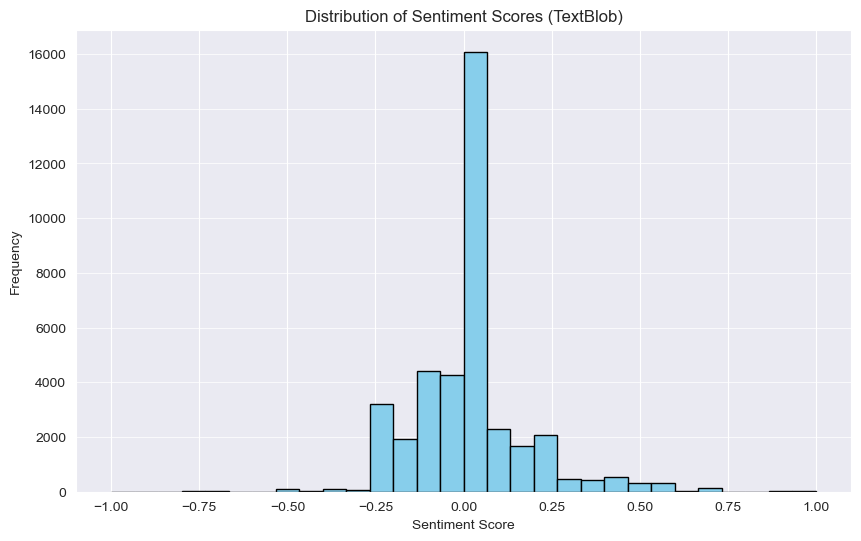

In [76]:
# Plot the distribution of sentiment scores
plt.figure(figsize=(10, 6))
plt.hist(df_textblob['TextBlob_Sentiment_Score'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Scores (TextBlob)')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

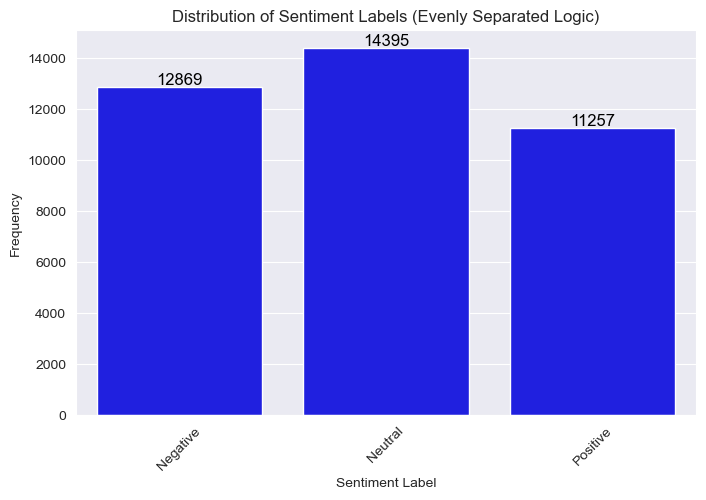

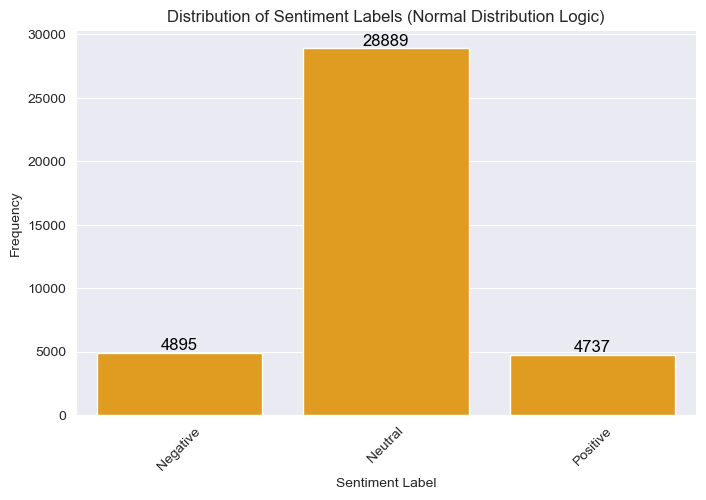

In [77]:
# Define the order of sentiment labels
sentiment_order = ['Negative', 'Neutral', 'Positive']

# Create a countplot with a single color for all bars for Evenly Separated Logic
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df_textblob, x='Evenly_Separated_Label', color='blue', order=sentiment_order)
plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Labels (Evenly Separated Logic)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add the actual frequency values on top of the bars without decimal values
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, color='black')

plt.show()

# Create a countplot with a single color for all bars for Normal Distribution Logic
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df_textblob, x='Normal_Distribution_Label', color='orange', order=sentiment_order)
plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Labels (Normal Distribution Logic)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add the actual frequency values on top of the bars without decimal values
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, color='black')

plt.show()

### 2nd Approach with NLTK (VADER)

In [ ]:
used_approach = "NLTK_VADER" #setting it for later reference

# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis and store the compound score in a new column
df_nltk['NLTK_Sentiment'] = df_nltk['Cleaned_Text'].apply(lambda text: sia.polarity_scores(text)['compound'])

# Record the start time
start_time = time.time()

for i, row in enumerate(df_nltk.index):
    text = df_nltk.at[row, 'Cleaned_Text']
    sentiment_score = sia.polarity_scores(text)['compound']
    df_nltk.at[row, 'NLTK_Sentiment'] = sentiment_score

    # Print progress message
    print(f"Text number {i + 1} out of all {total_rows} rows in the input file: Sentiment score = {sentiment_score}.")

# Calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

print("-"*100)

In [ ]:
# Calculate hours, minutes, and seconds from the elapsed time
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

# Format the elapsed time string
elapsed_time_str = f"{hours} hours, {minutes} mins, and {seconds} secs"

# End information about the run
print(f"The used approach was {used_approach}.")
print(f"Elapsed time: {elapsed_time_str}.")

In [ ]:
# Saving the output in two file formats in dedicated files for only this current approach in the correct repository folder

# Save the results to an Excel file
excel_output_file_nltk = os.path.join(output_folder, 'sentiment_results_nltk.xlsx')
df_nltk.to_excel(excel_output_file_nltk, index=False)

# Save the results to a csv file with the same name
csv_output_file_nltk = os.path.join(output_folder, 'sentiment_results_nltk.csv')
df_nltk.to_csv(csv_output_file_nltk, index=False, encoding='utf-8', quoting=csv.QUOTE_ALL)

# Print final info
print(f"Results saved as {csv_output_file_nltk} and {excel_output_file_nltk}.")

### Explorative Analysis of NLTK (VADER)

### 3rd Approach with BERT-based models

#### Short intro
**B**idirectional **E**ncoder **R**epresentations from **T**ransformers (**BERT**) is a family of language models introduced in 2018 by researchers at Google.
BERT is an "encoder-only" transformer architecture.

On a high level, BERT consists of three modules:

- **embedding**. This module converts an array of one-hot encoded tokens into an array of vectors representing the tokens.
- a **stack of encoders**. These encoders are the Transformer encoders. They perform transformations over the array of representation vectors.
- **un-embedding**. This module converts the final representation vectors into one-hot encoded tokens again.

There are different BERT models available out there.

**BERT-Large (e.g., bert-large-uncased):**
- one of the largest versions of BERT, with more parameters, making it capable of handling longer text
- high accuracy; can capture detailed context
- requires substantial computational resources and may be slower to run

**RoBERTa (e.g., roberta-large):**
- similar to BERT, but fine-tuned for better performance
- has been optimized for efficiency, can handle longer text as well
- often performs at par with BERT-Large but with lower computational requirements

**Longformer (e.g., allenai/longformer-large-4096):**
- designed specifically for handling long documents and sequences
- well-suited for tasks involving lengthy text, like news articles
- significantly extends the maximum token limit (e.g., up to 4096 tokens) compared to traditional BERT models

**Electra (e.g., google/electra-large-discriminator):**
- efficient and performs well on various NLP tasks
- not explicitly designed for long text, but it can still be used for document-level sentiment analysis effectively

**DistilBERT (e.g., distilbert-base-uncased):**
- smaller and more efficient version of BERT.
- may have limitations in handling very long texts due to its reduced model size

#### Using BERT-Large

In [ ]:
# Load the BERT-Large model and tokenizer
used_approach = "BERT-Large" #setting it for later reference

model_name = 'bert-large-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)
model.eval()

# Create lists to store the results
sentiments = []

# Record the start time
start_time = time.time()

# Loop through each row in the DataFrame
for current_row, (index, row) in enumerate(df_bert_large.iterrows(), start=1):
    text = row['Cleaned_Text']

    # Pre-process the text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)

    # Perform sentiment analysis
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = F.softmax(logits, dim=1)  # Use the PyTorch softmax function

    # Extract the predicted sentiment label
    predicted_label = torch.argmax(probabilities).item()  # NOTE: Only labels are easily available from BERT, no raw sentiment score or similar.
    sentiment_labels = ["Negative", "Neutral", "Positive"]  # Customize as needed
    predicted_sentiment = sentiment_labels[predicted_label]

    # Append the result to the lists
    sentiments.append(predicted_sentiment)

    # Print progress update
    print(f"Analyzing text number {current_row} out of {total_rows} rows in the input file.")

# Add the sentiments and the raw sentiment scores as new columns to the DataFrame
df_bert_large['BERT_Large_Sentiment'] = sentiments

# Calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

print("-"*100)

In [ ]:
# Calculate hours, minutes, and seconds from the elapsed time
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

# Format the elapsed time string
elapsed_time_str = f"{hours} hours, {minutes} mins, and {seconds} secs"

# End information about the run
print(f"The used approach was {used_approach}.")
print(f"Elapsed time: {elapsed_time_str}.")

In [ ]:
# Saving the output in two file formats in dedicated files for only this current approach in the correct repository folder

# Save the results to an Excel file
excel_output_file_BERT_large = os.path.join(output_folder, 'sentiment_results_BERT_large.xlsx')
df_bert_large.to_excel(excel_output_file_BERT_large, index=False)

# Save the results to a csv file with the same name
csv_output_file_BERT_large = os.path.join(output_folder, 'sentiment_results_BERT_large.csv')
df_bert_large.to_csv(csv_output_file_BERT_large, index=False, encoding='utf-8', quoting=csv.QUOTE_ALL)

# Print final info
print(f"Results saved as {csv_output_file_BERT_large} and {excel_output_file_BERT_large}.")

#### Explorative Analysis of BERT-Large

In [ ]:
# Count the occurrences of each sentiment label
sentiment_counts = df_bert_large['BERT_Large_Sentiment'].value_counts()

# Define the order of sentiment categories
sentiment_order = ['Positive', 'Neutral', 'Negative']

# Define colors for the sentiment categories
colors = {'Positive': 'green', 'Neutral': 'gray', 'Negative': 'red'}

# Create a bar plot (histogram) for sentiment distribution with correct colors and order
plt.figure(figsize=(8, 6))
sns.set_palette([colors[s] for s in sentiment_order])
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, order=sentiment_order)
plt.title('Sentiment Distribution - BERT-Large')
plt.xlabel('Sentiment Label')
plt.ylabel('Count of Sentiment')

plt.show()

#### Using German Sentiment

In [ ]:
used_approach = "German_Sentiment"  # setting it for later reference

# Load the German Sentiment model
model = SentimentModel()

# Record the start time
start_time = time.time()

# Initialize empty lists to store results
predicted_sentiments = []
sentiment_probabilities = []

# Loop through each row in the DataFrame
for current_row, row in enumerate(df_german_sentiment.itertuples(), start=1):
    text = row.Cleaned_Text  # Access 'Cleaned_Text' directly
    classes, probabilities = model.predict_sentiment([text], output_probabilities=True)
    predicted_sentiment = classes[0]
    sentiment_score = probabilities[0]

    predicted_sentiments.append(predicted_sentiment)
    sentiment_probabilities.append(sentiment_score)

    # Print progress update
    print(f"Analyzing text number {current_row} out of {len(df_german_sentiment)} rows in the input file.")

# Add the sentiments and probabilities as new columns to the DataFrame
df_german_sentiment['German_Sent_Predicted_Sentiment'] = predicted_sentiments
df_german_sentiment['German_Sent_Sentiment_Probability'] = sentiment_probabilities

# Calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

print("-" * 100)

In [ ]:
# Saving the output in two file formats in dedicated files for only this current approach in the correct repository folder

# Save the results to an Excel file
excel_output_file_GerSent = os.path.join(output_folder, 'sentiment_results_GerSent.xlsx')
df_german_sentiment.to_excel(excel_output_file_GerSent, index=False)

# Save the results
# to a csv file with the same name
csv_output_file_GerSent = os.path.join(output_folder, 'sentiment_results_GerSent.csv')
df_german_sentiment.to_csv(csv_output_file_GerSent, index=False, encoding='utf-8', quoting=csv.QUOTE_ALL)

# Print final info
print(f"Results saved as {csv_output_file_GerSent} and {excel_output_file_GerSent}.")

#### Explorative Analysis of German Sentiment

## Merge Results

In [ ]:
# Define a dictionary to store DataFrames for different approaches
df_dict = {}

# Load DataFrames for each approach
approaches = ['textblob', 'nltk', 'bert_large', 'roberta', 'longformer']

for approach in approaches:
    file_path = f'data/sentiment_results/sentiment_results_{approach}.csv'
    df_dict[approach] = pd.read_csv(file_path)

# Initialize merged DataFrame with the first approach (TextBlob)
merged_df = df_dict['textblob']

# Loop through the approaches and merge their DataFrames
for approach in approaches[1:]:
    # Merge based on common columns (adjust as needed)
    merged_df = merged_df.merge(df_dict[approach], on=['Row_Number'], how='inner', suffixes=('', f'_{approach}'))

# After merging the DataFrames, move 'Row_Number' to the first column
merged_df.insert(0, 'Row_Number', merged_df.pop('Row_Number'))
# Now, 'Row_Number' is the first column in merged_df

# Drop not needed, duplicated columns (not best way to do so though)
columns_to_drop = ['Unternehmen_nltk','Newstyp_nltk', 'Quelle_nltk', 'Nearest_Date_nltk', 'Cleaned_Text_nltk', 'Stock_Value_nltk', 'Unternehmen_bert_large', 'Newstyp_bert_large', 'Quelle_bert_large', 'Nearest_Date_bert_large', 'Cleaned_Text_bert_large', 'Stock_Value_bert_large', 'Unternehmen_roberta','Newstyp_roberta', 'Quelle_roberta', 'Nearest_Date_roberta', 'Cleaned_Text_roberta', 'Stock_Value_roberta', 'Unternehmen_longformer','Newstyp_longformer', 'Quelle_longformer', 'Nearest_Date_longformer', 'Cleaned_Text_longformer', 'Stock_Value_longformer']  # Add all columns you want to drop to this list
merged_df.drop(columns=columns_to_drop, inplace=True)


# Define the folder path
output_folder = 'data/sentiment_results/'

# Save the final merged DataFrame to CSV and Excel files in the specified folder path
merged_df.to_csv(os.path.join(output_folder, 'combined_sentiment_results.csv'), index=False)
merged_df.to_excel(os.path.join(output_folder, 'combined_sentiment_results.xlsx'), index=False)

print("Combined sentiment results saved to Excel and CSV files.")